In this assignment you'll have to explore and classify time series. The dataset is [FordA](http://www.timeseriesclassification.com/description.php?Dataset=FordA), which is a set of recordings of engine noise under typical conditions and you need to classify if certain condition exists.

In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting improts
import seaborn as sns

In [3]:
# Generic imports
import pathlib

# DS imports
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report

## Constants

In [4]:
DATA_DIR = pathlib.Path("")
DATASET = "FordA"

# Loading the data

Data files are stored in tabular format:

In [5]:
!head -n 2 FordA/FordA_TRAIN.txt

  -1.0000000e+00  -7.9717168e-01  -6.6439208e-01  -3.7301463e-01   4.0815121e-02   5.2693599e-01   9.8428794e-01   1.3531202e+00   1.5781078e+00   1.6592509e+00   1.6408093e+00   1.5522896e+00   1.4379516e+00   1.2793537e+00   1.0691193e+00   7.4454700e-01   2.7760541e-01  -3.0072351e-01  -9.3732792e-01  -1.5200828e+00  -1.9516165e+00  -2.1360326e+00  -2.0401363e+00  -1.7229406e+00  -1.2619003e+00  -8.0454833e-01  -4.6153436e-01  -2.7822475e-01  -2.5130000e-01  -3.0183001e-01  -3.1326381e-01  -2.0445830e-01   6.7002208e-02   4.7161115e-01   9.3265143e-01   1.3531202e+00   1.6444976e+00   1.7588356e+00   1.6961341e+00   1.4822114e+00   1.1797690e+00   8.2569008e-01   4.4948122e-01   7.2534692e-02  -2.9703519e-01  -6.4595047e-01  -9.7421115e-01  -1.2508353e+00  -1.4094332e+00  -1.4278748e+00  -1.3024718e+00  -1.0627309e+00  -7.4922349e-01  -4.1727450e-01  -1.0745543e-01   1.6879990e-01   3.9784471e-01   5.7488417e-01   6.8553384e-01   7.1872874e-01   6.7815720e-01   5.4906592e-01   3.325

In [6]:
train = pd.read_csv(DATA_DIR.joinpath(DATASET, f"{DATASET}_TRAIN.txt"),
                    header=None,
                    sep="\s+",
                    skipinitialspace=True)
test = pd.read_csv(DATA_DIR.joinpath(DATASET, f"{DATASET}_TEST.txt"),
                   header=None,
                   sep="\s+",
                   skipinitialspace=True)

In [7]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


So, each row represents a single measurement, with column `0` being class label, and columns `1-501` being measured values. Let's check missing values:

In [8]:
train.notnull().sum(axis=1).unique()

array([501])

In [9]:
test.notnull().sum(axis=1).unique()

array([501])

Let's change column names to something meaningful:

In [10]:
train.rename({0: "label"}, axis=1, inplace=True)
test.rename({0: "label"}, axis=1, inplace=True)

In [11]:
train.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)
test.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)

We can now select data values by filtering:

In [12]:
train.filter(like="val_")

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0.196022,-0.070102,-0.336226,-0.516799,-0.555282,-0.442793,-0.221369,0.025217,0.233320,0.350545,...,1.715205,1.129082,0.528158,-0.039020,-0.573043,-1.061479,-1.514392,-1.934743,-2.316612,-2.603753
3597,0.041994,0.422255,0.740529,0.975426,1.109891,1.137270,1.058349,0.894955,0.671224,0.421544,...,-0.463329,-0.392667,-0.333749,-0.316543,-0.340299,-0.392876,-0.450805,-0.482609,-0.467769,-0.393755
3598,-0.570054,-0.333165,-0.293519,-0.425344,-0.590869,-0.615648,-0.348033,0.275412,1.153586,2.035725,...,0.902821,0.579700,0.157463,-0.353980,-0.885246,-1.314421,-1.512655,-1.393714,-0.942733,-0.270722
3599,2.006732,2.079150,2.022036,1.867560,1.648112,1.379446,1.093717,0.784057,0.434150,0.029284,...,1.268671,1.148971,0.928088,0.634953,0.311682,-0.007376,-0.270543,-0.432145,-0.441231,-0.280709


The dataset is almost balanced:

In [13]:
train.iloc[:, 0].value_counts()

-1.0    1846
 1.0    1755
Name: label, dtype: int64

In [14]:
test.iloc[:, 0].value_counts()

-1.0    681
 1.0    639
Name: label, dtype: int64

# Task 1: explore time series

In this task you need to plot data samples with class label designation. Consider 10 or 20 random samples, and create a `2 x 5` or `4 x 5` plot, with eash subplot being the data records (i. e. `train.filter(like="val_").iloc[<sample_idx>]`), subtitles displaying sample index and class label. You can use color as well.


In [15]:
N_SAMPLES = 20
N_COLS = 5
N_ROWS = N_SAMPLES // N_COLS

samples = train.sample(N_SAMPLES, replace=False)

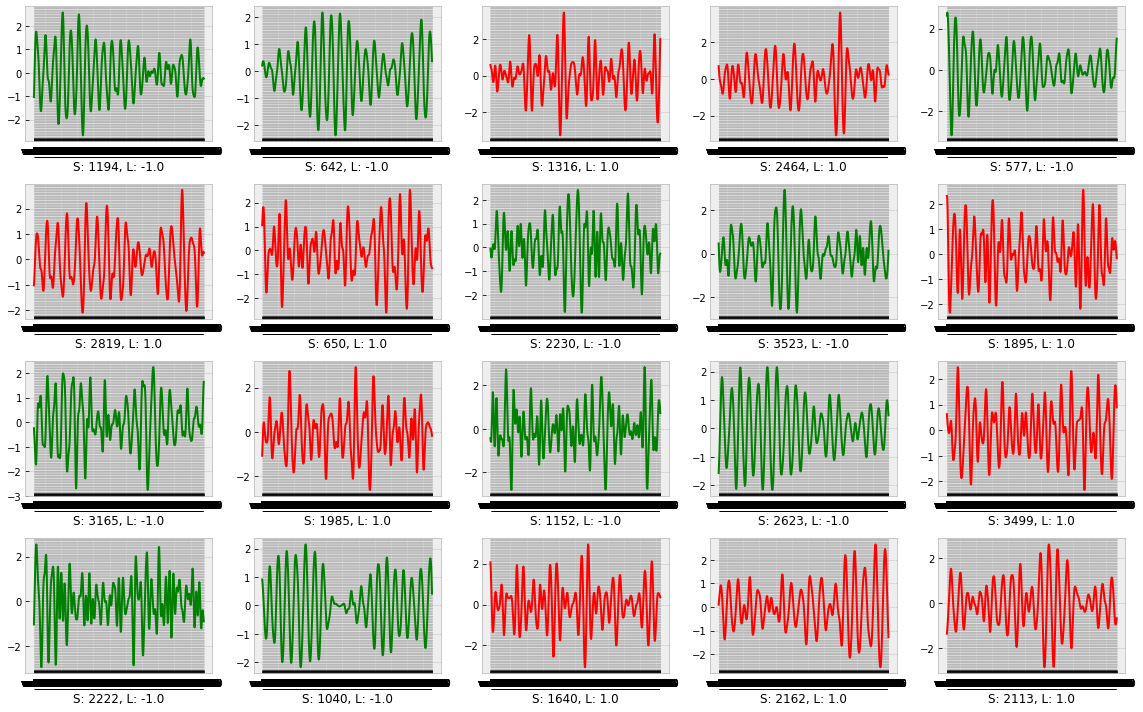

In [16]:
# plt.figure(figsize=(5 * N_ROWS, 5 * N_COLS))
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(16, 10))
row = -1

for si, (sidx, sample) in enumerate(samples.iterrows()):
    col = si % N_COLS
    if col == 0:
        row += 1
    # print(sample['label'])
    # plot one sample here on a corresponding subplot
    # print(sample.filter(like="val_"))
    if sample["label"] == 1.0:
        color = 'red'
    else:
        color = 'green'
    axs[row,col].plot(sample.filter(like="val_"), color=color) 
    axs[row,col].set_xlabel(f'S: {sidx}, L: {sample["label"]}')

plt.tight_layout();

# Task 2: explore statistics

In this task you need to plot simple statistics for each class, i. e. calculate `mean`, `median`, `std` and other statistics (of your choice) for each row and then visualize them in such a way, that one can figure out if a distribution of a given statistics differs between class `1` and `-1`.

**Hint:** you can consider [violin plots](https://seaborn.pydata.org/examples/grouped_violinplots.html) or [scatter plot matrix](https://seaborn.pydata.org/examples/scatterplot_matrix.html) helpful.

## Example: median

In [17]:
train["data_median"] = train.filter(like="val_").median(axis=1)
test["data_median"] = test.filter(like="val_").median(axis=1)

The simplest visualization possible (you need to create smth more elaborated for other features altogether):

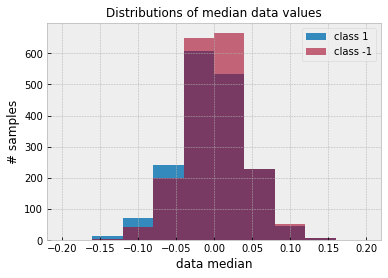

In [18]:
train.loc[train["label"]==1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), label="class 1")
train.loc[train["label"]==-1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("data median")
plt.ylabel("# samples")
plt.title("Distributions of median data values", fontsize=12);

**Note:** we can easily check if median is a good feature with ROC curve and score (as they do not rely on any specific normalization of the "predicted" probabilities). Think on why we're using `-data_median`.

In [19]:
fpr, tpr, thr = roc_curve(train["label"], -train["data_median"])

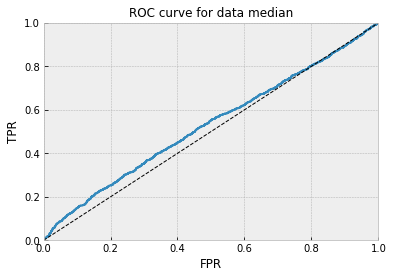

In [20]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data median", fontsize=12);

Ok, median contains *some* information (i. e. looking at median values is better than random classifier), but cannot serve as a *single* feature.

## Exploration

In [21]:
# plot other statistics here - mean, std, skew, max, min, some quantiles
# consider calculating ROC AUC for each feature to perform a preliminary filtering of irrelevant features
# beware of NaNs - some statistics may be broken for some rows

<AxesSubplot:xlabel='label', ylabel='data_mean'>

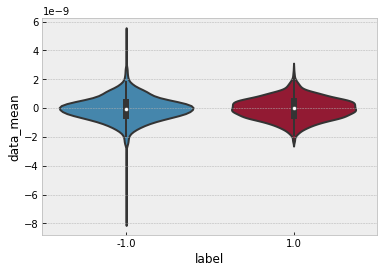

In [36]:
train["data_mean"] = train.filter(like="val_").mean(axis=1)
test["data_mean"] = test.filter(like="val_").mean(axis=1)
sns.violinplot(data=train, x="label", y='data_mean')

<AxesSubplot:xlabel='label', ylabel='data_std'>

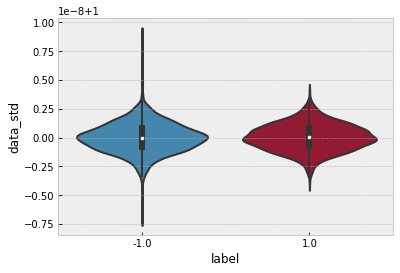

In [37]:
train["data_std"] = train.filter(like="val_").std(axis=1)
test["data_std"] = test.filter(like="val_").std(axis=1)
sns.violinplot(data=train, x="label", y='data_std')

# Task 3: explore advanced features

In this task you need to calculate and analyze other time series features. looking on the data sample, think on which features in time/frequency domains may be useful for a classification of the dataset.

**Hint:** try various features from [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

## Example: 0-crossings

For this features we'll not use `tsfresh`, and will do some ninja stuff in Pandas itself:

**Step 1:** mask on `> 0`.

In [24]:
mask = (train.filter(like="val_") > 0).astype(int)
mask

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,1,0,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,0
3597,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3598,0,0,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,0
3599,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0


**Step 2:** calc `diff` to get crossings (from `< 0` to `> 0`, or other way around).

In [25]:
mask.diff(axis=1) == 1  # crossing from -0 to +0

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3597,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3598,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3599,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [26]:
mask.diff(axis=1) == -1  # crossing from +0 to -0

,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_491,val_492,val_493,val_494,val_495,val_496,val_497,val_498,val_499,val_500
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3597,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3598,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3599,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


**Step 3:** calculate counts.

In [27]:
train["zero+"] = (mask.diff(axis=1) == 1).sum(axis=1)
train["zero-"] = (mask.diff(axis=1) == -1).sum(axis=1)

In [28]:
train["zero+"]

0       18
1       19
2       17
3       22
4       34
        ..
3596    21
3597    21
3598    32
3599    21
3600    20
Name: zero+, Length: 3601, dtype: int64

**Note:** we do not need to perform any normalization, as all samples have the same length.

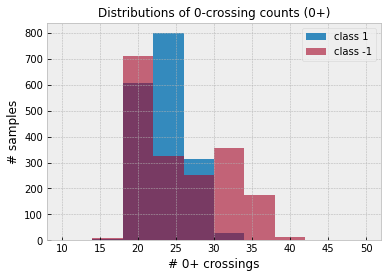

In [29]:
train.loc[train["label"]==1, "zero+"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero+"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0+ crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0+)", fontsize=12);

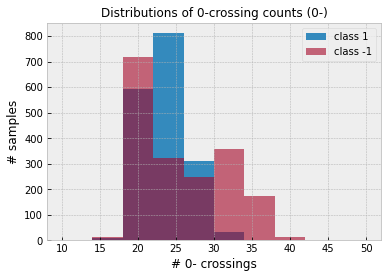

In [30]:
train.loc[train["label"]==1, "zero-"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero-"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0- crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0-)", fontsize=12);

Of course, for oscillatory time series `zero+` and `zero-` are highly correlated, so we may drop one of them:

In [31]:
train.filter(like="zero").corr()

,zero+,zero-
zero+,1.000000,0.988801
zero-,0.988801,1.000000


In [32]:
train.drop("zero-", axis=1, inplace=True)

The distribution of `zero+` looks fancy, and ROC curve reflects that:

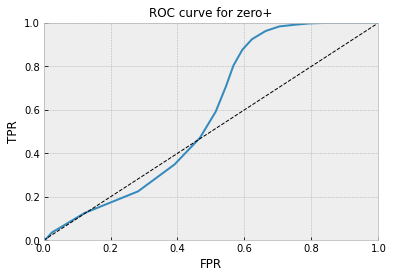

In [33]:
fpr, tpr, thr = roc_curve(train["label"], -train["zero+"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for zero+", fontsize=12);

Think on this in the following way.

Look at the histograms, and perform an estimate (no code, just in your head): given, that `zero+` is equal to `v`, what is the probability of a sample to belong to class `1`? Is this probability monotonic with `v`? How does this influence the choice of the model? Will logistic regression do the job here?

## Exploration

In [34]:
# plot other features here - you may find various spectral features helpful here
# perform an analysis similar to one we did with number of 0-crossings
# beware of NaNs - some statistics may be broken for some rows

# Task 4: modeling

Given all the features you selected in Tasks 2 and 3, create a binary  classification model. You need to perform:

- reasonable train/validation split of `train`,
- select a model type (out of those, available in `sklearn`, no need to go for, say, gradient boosting),
- train a model, validate it and calculate the final score (ROC AUC) for the test set.

In [35]:
# do the train/validation split
# train a model
# check the performance on the test set